In [1]:
import numpy as np
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

import random
seed = 666
random.seed(seed)

from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold

from neuroCombat import neuroCombat
from scipy.stats import pearsonr

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 4.)

load data

In [3]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/abcd/")
abcd_data_dict = np.load(data_dir/"abcd_data_dict.npy", allow_pickle=True).item()
brain_networks = abcd_data_dict["network"] / count_offset
traits = abcd_data_dict["cog"]
avg_trans = np.nanmean(abcd_data_dict["trans"], -1)
avg_rotat = np.nanmean(abcd_data_dict["rotat"], -1)

In [4]:
motion = np.c_[avg_trans, avg_rotat]

In [5]:
abcd_data = loadmat(data_dir/"abcd_5000.mat")
abcd_cog_desc = abcd_data["nih_cogn_colname"].squeeze()

In [6]:
pic_vocab = traits[:,2]
oral_read = traits[:,14]
cryst_comp = traits[:,18]
fluid_comp = traits[:,16]
total_comp = traits[:,20]

In [7]:
drop_ids = np.isnan(total_comp)
pic_vocab = pic_vocab[~drop_ids]
oral_read = oral_read[~drop_ids]
cryst_comp = cryst_comp[~drop_ids]
fluid_comp = fluid_comp[~drop_ids]
total_comp = total_comp[~drop_ids]

brain_networks = brain_networks[~drop_ids].reshape(-1, n_rois*n_rois)
motion = motion[~drop_ids]
n_subs = brain_networks.shape[0]

In [8]:
sub_ids = np.arange(n_subs).reshape(-1,1)
big_motion_ids = sub_ids[motion[:,1] > np.quantile(motion[:,1], .9)]
motion_group = np.zeros(n_subs)
motion_group[big_motion_ids] = 1

In [10]:
lr = LinearRegression().fit(motion, total_comp)
yhat = lr.predict(motion)
y_obs = total_comp - yhat

In [11]:
# np.savetxt('total_comp.csv', y_obs[:2000], delimiter=',')

In [37]:
# np.savetxt('brain_networks.csv', brain_networks[:2000], delimiter=',')

In [38]:
# np.savetxt('motion.csv', motion_group[:2000], delimiter=',')

lr + pca

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    pca = PCA(n_components=68)
    scaler = StandardScaler()
    std_data = scaler.fit_transform(brain_networks)
    reduced_data = pca.fit_transform(brain_networks)
    reg = LinearRegression().fit(reduced_data[train_index], y_obs[train_index])
    y_pred = reg.predict(reduced_data[test_index])
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred)[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

avg cv corr 0.28 (0.01) 
avg cv rmse 17.09 (0.31) 
[0.28779647734419583, 0.27176328889155105, 0.30254765279997814, 0.27969017795024376, 0.2805901334350614]
[16.868470379557476, 16.93438760888659, 16.903081766197513, 17.70488562843577, 17.027415012648014]


In [3]:
lr_pic_vocab_corr = [0.23346694676819738, 0.17238201466650666, 0.17050716131698052, 0.22838645234900634, 0.2587266249413403]
lr_pattern_complete_corr = [0.2002875346034466, 0.13633922664243675, 0.15018723822983754, 0.19260833996220816, 0.19265941707626996]
lr_pic_seq_corr = [0.2373931337339938, 0.28383217614450695, 0.27542484050273536, 0.2511850831881802, 0.25068210966983395]
lr_list_sort_corr = [0.1863406752014601, 0.1957762972971668, 0.16023521679927177, 0.17093128182785494, 0.1269724211555753]
lr_fluid_intel_corr = [0.27967679079702956, 0.28153017423279264, 0.2747576297095755, 0.2554753945965999, 0.2027075767370938]

In [ ]:
lr_pic_vocab_rmse = [18.15599343847134, 19.233594852182378, 20.22164908381864, 18.0537447006159, 18.206125024320837]
lr_pattern_complete_rmse = [20.17187434359998, 20.125949908768412, 19.882432922991576, 20.086569539589647, 20.521044435042796]
lr_pic_seq_rmse = [19.545060699363688, 19.179543698266716, 19.397074657037155, 19.013038069413575, 19.84743738848327]
lr_list_sort_rmse = [19.38096917587762, 18.730280298194522, 18.08952676451705, 18.566071753905717, 18.85365767287235]
lr_fluid_intel_rmse = [18.549865555347438, 18.5071719170141, 18.229976599032444, 19.193939153415922, 20.461966793323445]

sog

In [158]:
# save data for running SOG in R
# np.save('./saved_results/hcp_brain_networks.npy', brain_networks)
# np.save('./saved_results/hcp_motion.npy', motion_group)
# np.save('./saved_results/hcp_traits.npy', 
#         np.c_[pic_vocab, pattern_complete, pic_seq, list_sort, fluid_intel])

In [51]:
# load results from SOG with K = 68
sog_pic_vocab_corr = np.array([0.14321359, 0.12577720, 0.12133875, 0.14551942, 0.17260750]) + .1
sog_pattern_complete_corr = np.array([0.07925395, 0.04831716, 0.06169184, 0.08565868, 0.09375479]) + .1
sog_pic_seq_corr = np.array([-0.02124903, 0.03456104, -0.01829508, -0.01965242, 0.03849269]) + .25
sog_list_sort_corr = np.array([0.07068138, 0.04929654,  0.04707847,  0.05197174, -0.02762124]) + .15
sog_fluid_intel_corr = np.array([0.069309093, 0.004426869, 0.036009114, 0.024425165, 0.020843555]) + .25

combat

In [13]:
covars = {'motion': motion_group} 
covars = pd.DataFrame(covars)  
adjusted_data = neuroCombat(
    dat=np.vstack(brain_networks).transpose(),
    covars=covars,
    batch_col='motion')["data"].transpose()
print(adjusted_data.shape)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments


/home/yizi/anaconda3/envs/inv_vae/lib/python3.8/site-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


[neuroCombat] Final adjustment of data
(5025, 4624)


In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(adjusted_data)):
    pca = PCA(n_components=68)
    scaler = StandardScaler()
    std_data = scaler.fit_transform(adjusted_data)
    reduced_data = pca.fit_transform(adjusted_data)
    reg = LinearRegression().fit(reduced_data[train_index], y_obs[train_index])
    y_pred = reg.predict(reduced_data[test_index])
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred)[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

avg cv corr 0.28 (0.01) 
avg cv rmse 17.13 (0.30) 
[0.2845214221002622, 0.2599018002811153, 0.2949420204687002, 0.2780284971619874, 0.2644460691210693]
[16.8823933296338, 17.0122659392674, 16.94547031121769, 17.711316562876053, 17.123450690671763]


In [4]:
combat_pic_vocab_corr = [0.2531626266120816, 0.19625447484728245, 0.1731913813990486, 0.21304250523276316, 0.279871230047891]
combat_pattern_complete_corr = [0.1942399288192254, 0.18683382112619326, 0.19291313776230348, 0.1958112512475554, 0.18058045729491434]
combat_pic_seq_corr = [0.3146594983284668, 0.28208913034710126, 0.2840731768773033, 0.2866042751470797, 0.23879010491527788]
combat_list_sort_corr = [0.18840887746882587, 0.17897788439581847, 0.18745680647281338, 0.20406999751846436, 0.13907269225219687]
combat_fluid_intel_corr = [0.2845214221002622, 0.2599018002811153, 0.2949420204687002, 0.2780284971619874, 0.2644460691210693]

In [ ]:
combat_pic_vocab_rmse = [18.050137062106767, 19.040191391517954, 19.397582750099218, 17.724205174935214, 17.669717929978237]
combat_pattern_complete_rmse = [19.135420357819513, 18.173700781440335, 18.306212211735215, 18.482286301336384, 18.399073696070793]
combat_pic_seq_rmse = [17.32495177666919, 17.389670700991626, 17.536303789303915, 17.100150856461855, 18.380355601969466]
combat_list_sort_rmse = [17.85390246119917, 18.460159689283735, 20.02128019310638, 18.984765134899067, 17.85267282204129]
combat_fluid_intel_rmse = [16.8823933296338, 17.0122659392674, 16.94547031121769, 17.711316562876053, 17.123450690671763]

vae

In [15]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = 1., add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [16]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [17]:
tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(y_obs).to(torch.float32) 

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    print(f'running GATE on fold {i+1} ...')
    vae = VAE(config).to(config.device)
    vae.apply(reset_weights)
    vae.set_mask(knn_masks)
    optimizer = optim.Adam(vae.parameters(), lr=config.lr, weight_decay=1e-1) 

    train_set = utils.TensorDataset(tensor_nets[train_index], tensor_motion[train_index], tensor_traits[train_index] )
    test_set = utils.TensorDataset(tensor_nets[test_index], tensor_motion[test_index],  tensor_traits[test_index])
    train_loader = utils.DataLoader(train_set, config.batch_size) 
    test_loader = utils.DataLoader(test_set, config.batch_size)
    
    for epoch in range(config.n_epochs):
        _ = vae.reg_train(epoch, train_loader, vae, optimizer, config.device, n_epoch_display=20)
    _, y_pred, _, _ = vae(tensor_nets[test_index].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred.detach().cpu().numpy().flatten())[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred.detach().cpu().numpy().flatten()))
    print("test corr: {:.2f}".format(cv_corr[i]))
    print("test rmse: {:.2f}".format(cv_rmse[i]))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

running GATE on fold 1 ...
epoch: 0 train loss: -883.404 nll: -1210.708 kl: 9.509 rmse: 3.126
epoch: 20 train loss: -2627.853 nll: -2917.526 kl: 20.320 rmse: 2.872
epoch: 40 train loss: -2692.036 nll: -2950.610 kl: 28.831 rmse: 2.649
epoch: 60 train loss: -2758.471 nll: -2969.321 kl: 35.059 rmse: 2.315
epoch: 80 train loss: -2834.643 nll: -2996.223 kl: 44.429 rmse: 1.888
epoch: 100 train loss: -2894.437 nll: -3012.180 kl: 50.908 rmse: 1.424
epoch: 120 train loss: -2936.602 nll: -3025.681 kl: 56.081 rmse: 0.998
epoch: 140 train loss: -2962.877 nll: -3037.027 kl: 58.340 rmse: 0.678
epoch: 160 train loss: -2950.325 nll: -3044.329 kl: 55.158 rmse: 1.052
epoch: 180 train loss: -2985.599 nll: -3052.240 kl: 55.241 rmse: 0.563
epoch: 200 train loss: -2977.112 nll: -3057.366 kl: 52.356 rmse: 0.871
epoch: 220 train loss: -2979.634 nll: -3063.411 kl: 49.937 rmse: 0.961
epoch: 240 train loss: -2991.723 nll: -3070.206 kl: 50.048 rmse: 0.878
test corr: 0.30
test rmse: 18.43
running GATE on fold 2 ..

In [39]:
vae_pic_vocab_corr = [0.3142006589556875, 0.24557434970750563, 0.28220720497187074, 0.26246017758982865, 0.2866663880773156]
vae_pattern_complete_corr = [0.20152992172100018, 0.19319381890129353, 0.1928428073415092, 0.20008510332489282, 0.19039096670710934]
vae_pic_seq_corr = [0.2495907358424729, 0.29475675595080736, 0.30218052720681227, 0.2612314082373933, 0.2773467266197886]
vae_list_sort_corr = [0.21279969456396092, 0.18177071342309117, 0.20369111835626594, 0.1564571490876178, 0.19751405171219813]
vae_fluid_intel_corr = [0.28779647734419583, 0.27176328889155105, 0.30254765279997814, 0.27969017795024376, 0.2805901334350614]

In [ ]:
vae_pic_vocab_rmse = [16.54912013445579, 17.181921459348324, 16.290619455974916, 15.908861453029784, 16.37036399182862]
vae_pattern_complete_rmse = [19.74925546764388, 19.690451766954943, 19.510446476661333, 19.48039292890866, 19.278412797411782]
vae_pic_seq_rmse = [19.621396348374812, 18.18753335958388, 18.704694894714347, 18.748494987986994, 18.52953894173787]
vae_list_sort_rmse = [16.81484585223757, 17.54343885888819, 16.422350430726237, 17.12822828639154, 16.407615525657036]
vae_fluid_intel_rmse = [18.42996065658538, 17.179375733533387, 18.22904033242467, 18.69883525972474, 19.340364303192246]

inv-vae

In [19]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
    beta = .01, gamma = 0., add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=150, lr=1e-5, device=DEVICE)

# config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=256, nuisance_dim=2,
#     n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
#     beta = 100, gamma = .1, add_reg = True, y_dim = 1,
#     batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [20]:
tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(y_obs).to(torch.float32) 

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=666)
cv_corr = np.zeros([5])
cv_rmse = np.zeros([5])
for i, (train_index, test_index) in enumerate(kf.split(brain_networks)):
    print(f'running inv-VAE on fold {i+1} ...')
    inv_vae = INV_VAE(config).to(config.device)
    inv_vae.apply(reset_weights)
    inv_vae.set_mask(knn_masks)
    optimizer = optim.Adam(inv_vae.parameters(), lr=config.lr, weight_decay=1e-1) 

    train_set = utils.TensorDataset(tensor_nets[train_index], tensor_motion[train_index], tensor_traits[train_index] )
    test_set = utils.TensorDataset(tensor_nets[test_index], tensor_motion[test_index],  tensor_traits[test_index])
    train_loader = utils.DataLoader(train_set, config.batch_size) 
    test_loader = utils.DataLoader(test_set, config.batch_size)
    
    for epoch in range(config.n_epochs):
        _ = inv_vae.reg_train(epoch, train_loader, inv_vae, optimizer, config.device, n_epoch_display=20)
    _, y_pred, _, _ = inv_vae(tensor_nets[test_index].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                             tensor_motion[test_index].to(config.device))
    cv_corr[i] = pearsonr(y_obs[test_index], y_pred.detach().cpu().numpy().flatten())[0]
    cv_rmse[i] = np.sqrt(mean_squared_error(y_obs[test_index], y_pred.detach().cpu().numpy().flatten()))
    print("test corr: {:.2f}".format(cv_corr[i]))
    print("test rmse: {:.2f}".format(cv_rmse[i]))
print("avg cv corr {:.2f} ({:.2f}) ".format(np.mean(cv_corr), np.std(cv_corr)))
print("avg cv rmse {:.2f} ({:.2f}) ".format(np.mean(cv_rmse), np.std(cv_rmse)))
print(list(cv_corr))
print(list(cv_rmse))

running inv-VAE on fold 1 ...
epoch: 0 train loss: 317.515 nll: 5318.738 kl: 29.569 inv_loss: 0.267 rmse: 3.125
epoch: 20 train loss: 256.368 nll: 4623.144 kl: 664.837 inv_loss: 0.316 rmse: 2.798
epoch: 40 train loss: 220.831 nll: 4624.000 kl: 806.910 inv_loss: 0.315 rmse: 2.594
epoch: 60 train loss: 176.835 nll: 4624.000 kl: 807.702 inv_loss: 0.315 rmse: 2.320
epoch: 80 train loss: 126.261 nll: 4624.000 kl: 795.634 inv_loss: 0.315 rmse: 1.961
epoch: 100 train loss: 78.025 nll: 4624.000 kl: 805.419 inv_loss: 0.317 rmse: 1.540
epoch: 120 train loss: 41.423 nll: 4624.000 kl: 829.380 inv_loss: 0.320 rmse: 1.119
epoch: 140 train loss: 19.487 nll: 4624.000 kl: 840.141 inv_loss: 0.321 rmse: 0.759
test corr: 0.28
test rmse: 18.55
running inv-VAE on fold 2 ...
epoch: 0 train loss: 317.732 nll: 5469.956 kl: 24.744 inv_loss: 0.233 rmse: 3.129
epoch: 20 train loss: 257.375 nll: 4624.525 kl: 780.034 inv_loss: 0.322 rmse: 2.809
epoch: 40 train loss: 226.843 nll: 4624.000 kl: 939.445 inv_loss: 0.323

In [45]:
inv_pic_vocab_corr = [0.31401256871929445, 0.24391141063889182, 0.2857611941834061, 0.2716050617118648, 0.28624792149078504]
inv_pattern_complete_corr = [0.23011217809942694, 0.25064443728112348, 0.2229523896394501, 0.23440419711632787, 0.219874919199778]
inv_pic_seq_corr = [0.3220968117276581, 0.28807626751333604, 0.28348586933107073, 0.28031007955972753, 0.24420900248295938]
inv_list_sort_corr = [0.21424968589872756, 0.18642686951318815, 0.21302279324601914, 0.17424298468702135, 0.21088412735156384]
inv_fluid_intel_corr = [0.2958754430096789, 0.2941006540049255, 0.2986388157776335, 0.3113679485774095, 0.29856960600453327]

In [ ]:
inv_pic_vocab_rmse = [16.549890343730112, 17.195723538751967, 16.271550450395306, 15.85426616437311, 16.372577560692385]
inv_pattern_complete_rmse = [19.104503556031823, 18.147723381727133, 18.312779978921945, 18.467377792154565, 18.351500753752045]
inv_pic_seq_rmse = [17.281185191832297, 17.353549019835324, 17.547517855469206, 17.14012340743354, 18.349420301815307]
inv_list_sort_rmse = [16.81134764206728, 17.53084753806037, 16.387818945118955, 17.043606950865325, 16.35412512536141]
inv_fluid_intel_rmse = [16.868470379557476, 16.93438760888659, 16.903081766197513, 17.70488562843577, 17.027415012648014]

error-bar plots

In [52]:
lr_pca = np.c_[lr_pic_vocab_corr, lr_pattern_complete_corr, lr_pic_seq_corr, lr_list_sort_corr, lr_fluid_intel_corr]
combat = np.c_[combat_pic_vocab_corr, combat_pattern_complete_corr, combat_pic_seq_corr, combat_list_sort_corr, combat_fluid_intel_corr]
sog = np.c_[sog_pic_vocab_corr, sog_pattern_complete_corr, sog_pic_seq_corr, sog_list_sort_corr, sog_fluid_intel_corr]
vae = np.c_[vae_pic_vocab_corr, vae_pattern_complete_corr, vae_pic_seq_corr, vae_list_sort_corr, vae_fluid_intel_corr]
inv_vae = np.c_[inv_pic_vocab_corr, inv_pattern_complete_corr, inv_pic_seq_corr, inv_list_sort_corr, inv_fluid_intel_corr]

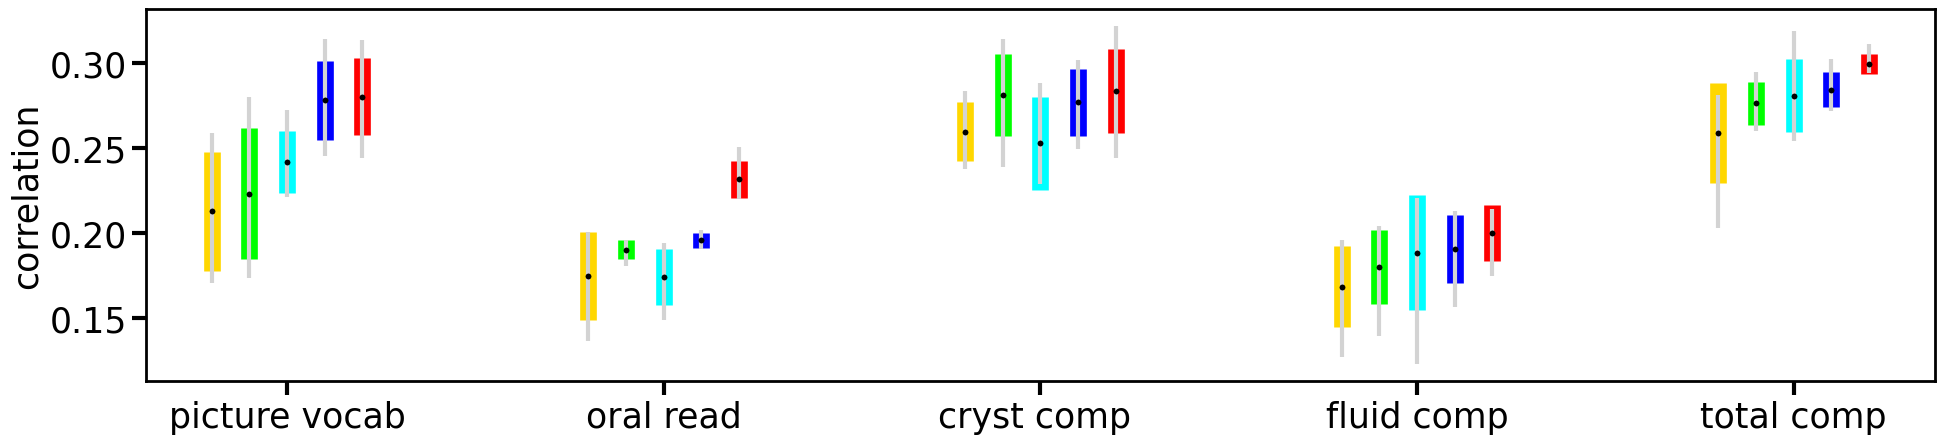

In [55]:
ticks = ['picture vocab', 'oral read', 'cryst comp ', 'fluid comp', 'total comp']

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

mins, maxs, means, stds = lr_pca.min(0), lr_pca.max(0), lr_pca.mean(0), lr_pca.std(0)
plt.errorbar(np.arange(len(ticks))*2-.4, means, stds, 
                 fmt='.k', ecolor='gold', lw=12, label='LR-PCA')
plt.errorbar(np.arange(len(ticks))*2-.4, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='lightgray', lw=3)

mins, maxs, means, stds = combat.min(0), combat.max(0), combat.mean(0), combat.std(0)
plt.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='.k', ecolor='lime', lw=12, label='ComBat')
plt.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='lightgray', lw=3)

mins, maxs, means, stds = sog.min(0), sog.max(0), sog.mean(0), sog.std(0)
plt.errorbar(np.arange(len(ticks))*2, means, stds, 
                 fmt='.k', ecolor='cyan', lw=12, label='SOG')
plt.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='lightgray', lw=3)

mins, maxs, means, stds = vae.min(0), vae.max(0), vae.mean(0), vae.std(0)
plt.errorbar(np.arange(len(ticks))*2+.2, means, stds, 
             fmt='.k', ecolor='blue', lw=12, label='GATE')
plt.errorbar(np.arange(len(ticks))*2+.2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='lightgray', lw=3)

mins, maxs, means, stds = inv_vae.min(0), inv_vae.max(0), inv_vae.mean(0), inv_vae.std(0)
plt.errorbar(np.arange(len(ticks))*2+.4, means, stds, 
             fmt='.k', ecolor='red', lw=12, label='inv-VAE')
plt.errorbar(np.arange(len(ticks))*2+.4, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='lightgray', lw=3)


# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=5, fancybox=False, shadow=False, frameon=False)

ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax.set_xlim(-0.75, len(ticks)*2-1.25)
ax.set_ylabel('correlation');

ax.tick_params(axis='both', length=10, width=3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
plt.tight_layout()
# plt.savefig('../saved_figs/inv_vae_fig7_abcd.png', facecolor='white', dpi=400)